# Historical Stock Revenue Analysis

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [2]:
def get_benchmark_index_per_country(country):
    country_index_df = pd.read_csv('country_index_mapping.csv')
    if country in country_index_df['Country'].values:
        index = country_index_df.loc[country_index_df['Country'] == country, 'Index'].values[0]
    else:
        index = None
    return index

In [3]:
def get_market_data(country,period=None, start=None, end=None):
    if period==None and start==None and end==None:
        period = 'max'
    elif start==None or end==None:
        if start==None:
            start = (datetime.now() - relativedelta(years=99)).strftime("%Y-%m-%d")
        if end==None:
            default_end = datetime.now().strftime("%Y-%m-%d")

    benchmark_index_symbol = get_benchmark_index_per_country(country)
    if benchmark_index_symbol == None:
        return None,None
    else:
        if period == None:
            market_df = pd.DataFrame(yf.Ticker(benchmark_index_symbol).history(start=start,end=end))
        else:
            market_df = pd.DataFrame(yf.Ticker(benchmark_index_symbol).history(period=period))
        market_df = market_df.rename(columns={'Close':'Adj_Close'})
        market_df['Simple_Returns'] = (market_df['Adj_Close'] + market_df['Dividends'])/market_df['Adj_Close'].shift(1) - 1
        market_variance = market_df['Simple_Returns'].var()
        return market_df['Simple_Returns'],market_variance

In [4]:
def get_stock_data(symbol,period=None, start=None, end=None):
    if period==None and start==None and end==None:
        period = 'max'
    elif start==None or end==None:
        if start==None:
            start = (datetime.now() - relativedelta(years=99)).strftime("%Y-%m-%d")
        if end==None:
            default_end = datetime.now().strftime("%Y-%m-%d")

    if symbol[-3:] == '.HK':
        country = 'Hong Kong'
    elif 'country' not in yf.Ticker('IVV').info.keys():
        country = None
    else:
        country = yf.Ticker(symbol).info['country']

    if period == None:
        stock_df = pd.DataFrame(yf.Ticker(symbol).history(start=start,end=end))
    else:
        stock_df = pd.DataFrame(yf.Ticker(symbol).history(period=period))
    #yfinance returns adj close as close automatically
    stock_df = stock_df.rename(columns={'Close':'Adj_Close'})

    stock_df['Simple_Returns'] = (stock_df['Adj_Close'] + stock_df['Dividends'])/stock_df['Adj_Close'].shift(1) - 1
    expected_return = stock_df['Simple_Returns'].mean()
    stock_volatility = stock_df['Simple_Returns'].std()
    stock_df['Log_Returns'] = np.log(stock_df['Adj_Close'] / stock_df['Adj_Close'].shift(1))

    if period == None:
        market_Simple_Returns,market_variance = get_market_data(country,start=start,end=end)
    else:
        market_Simple_Returns,market_variance = get_market_data(country,period)
    if market_variance != None:
        beta = (market_Simple_Returns.cov(stock_df['Simple_Returns']))/market_variance
    else:
        beta = None
    return stock_df, expected_return, stock_volatility, beta, country

In [5]:
def display_stock_data(symbol,period=None, start=None, end=None):
    if period==None and start==None and end==None:
        period = 'max'
    elif start==None or end==None:
        if start==None:
            start = (datetime.now() - relativedelta(years=99)).strftime("%Y-%m-%d")
        if end==None:
            default_end = datetime.now().strftime("%Y-%m-%d")
    
    print(f"{symbol}'s Data:")
    if period == None:
        stock_df,expected_return,stock_volatility, beta, country = get_stock_data(symbol, start=start,end=end)
    else:
        stock_df,expected_return,stock_volatility, beta, country = get_stock_data(symbol, period)
    print(f"Location: {country}")
    print(f"Stock Volatility: {stock_volatility*100:.2f}%")
    if beta != None:
        print(f"Stock Market Exposure: {beta:.4f}", end='')
        if beta > 1:
            print(" - High systematic risk.")
        elif beta <= 1 and beta > 0:
            print(" - Low systematic risk.")
        elif beta == 0:
            print(" - Uncorrelated.")
        elif beta < 0:
            print(" - Inverse systematic risk.")
        else:
            print(" - Error, most likely due to insufficient data or extreme stock volatility")
    else:
        print("Stock's country not available in database")

    colors = ['steelblue','orangered']
    
    stock_df['Adj_Close'].plot(figsize=(12,8), color = colors[0])
    plt.ylabel("Adjusted Close Price ($)")
    plt.title(f"{symbol}'s Price Data")
    plt.grid()
    plt.show()

    ax = (stock_df['Simple_Returns']*100).plot(figsize=(12,8), color = colors[0])
    plt.axhline(y=expected_return * 100, color=colors[1], linestyle='--')
    custom_lines = [Line2D([0], [0], color=colors[0], lw=4), Line2D([0], [0], color=colors[1], lw=4)]
    ax.legend(custom_lines, ['Realized Returns','Expected Return'])
    plt.ylabel(f"Return Percentage (%)")
    plt.title(f"{symbol}'s Daily Realized Returns vs Expected Return")
    plt.grid()
    plt.show()

    # plt.figure(figsize=(12,8))
    # plt.hist(stock_df['Simple_Returns'])
    # plt.show()

In [7]:
def get_stock_portfolio_data(symbol,money_invested_stock,money_invested_total,period=None,start=None,end=None):
    if period==None and start==None and end==None:
        period = 'max'
    elif start==None or end==None:
        if start==None:
            start = (datetime.now() - relativedelta(years=99)).strftime("%Y-%m-%d")
        if end==None:
            default_end = datetime.now().strftime("%Y-%m-%d")
    
    weight = money_invested_stock/money_invested_total
    
    if period == None:
        stock_df, expected_return, stock_volatility, beta, country = get_stock_data(symbol,start=start, end=end)
    else:
        stock_df, expected_return, stock_volatility, beta, country = get_stock_data(symbol,period=period)

    Returns = (stock_df['Simple_Returns'] * weight).sum()
    Risk=None
    return Returns, Risk

In [8]:
def get_full_portfolio_data(symbol_list,money_invested_list, start_list, end_list=None):
    if end_list == None:
        end_list = [None]* len(symbol_list)

    portfolio_df = pd.DataFrame(columns=['Stock_Symbol','Money_Invested','Start','End','Portfolio_Return','Portfolio_Risk'])
    portfolio_df['Stock_Symbol']= symbol_list
    portfolio_df['Money_Invested']= money_invested_list
    portfolio_df['Start']= start_list
    portfolio_df['End']= end_list
    money_invested_total = portfolio_df['Money_Invested'].sum()

    for idx, row in portfolio_df.iterrows():
        portfolio_return, portfolio_risk = get_stock_portfolio_data(row['Stock_Symbol'], row['Money_Invested'], money_invested_total, start=row['Start'], end=row['End'])
        portfolio_df.at[idx, 'Portfolio_Return'] = portfolio_return
        portfolio_df.at[idx, 'Portfolio_Risk'] = portfolio_risk
    return portfolio_df

005930.KS's Data:
Location: None
Stock Volatility: 1.56%
Stock's country not available in database


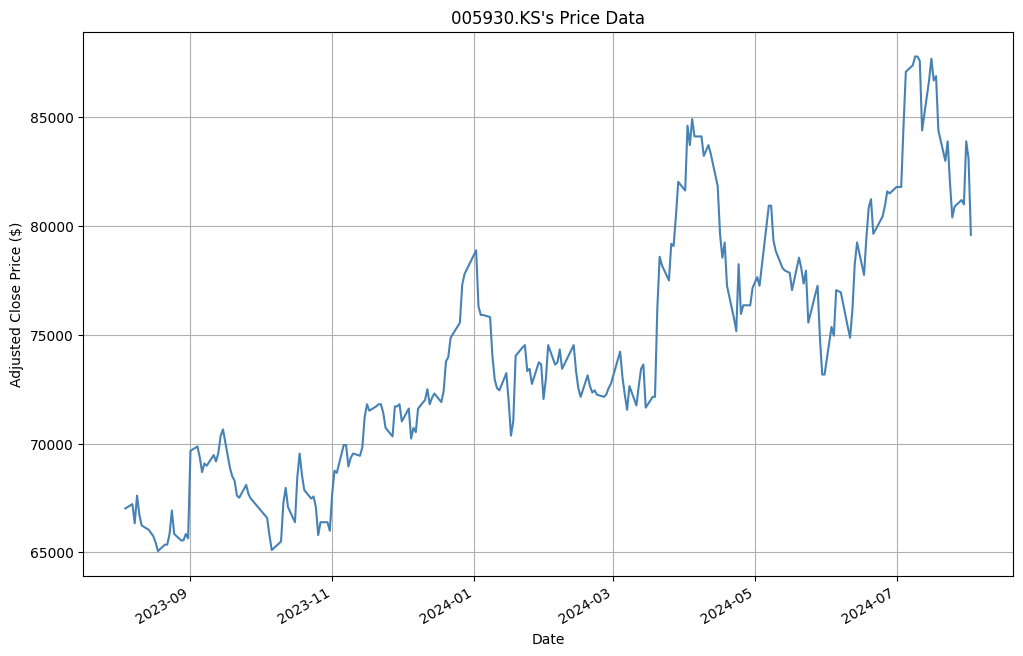

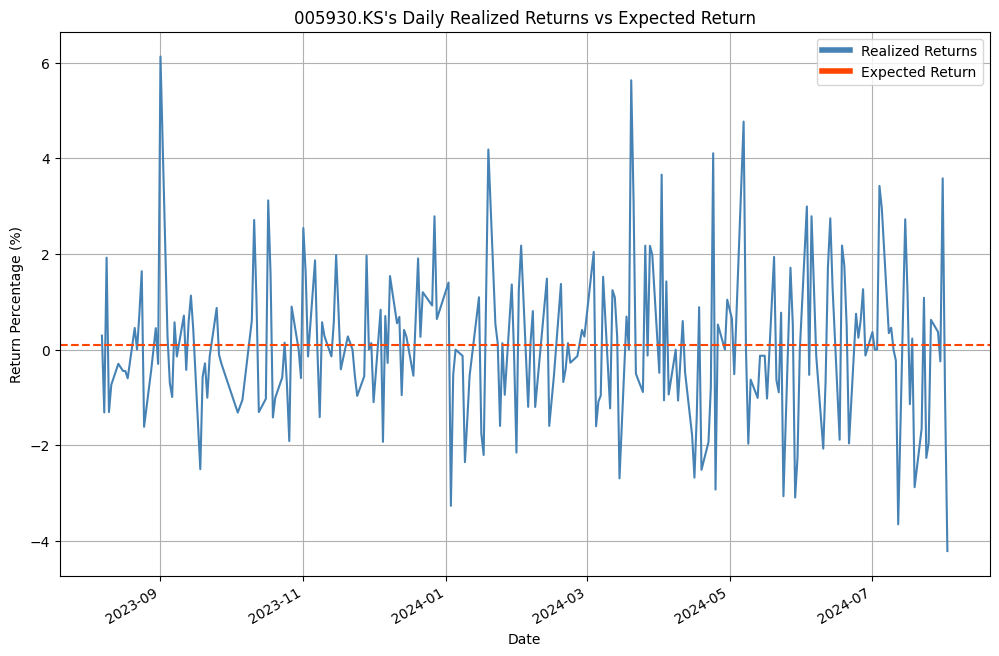

GOOGL's Data:
Location: None
Stock Volatility: 1.74%
Stock's country not available in database


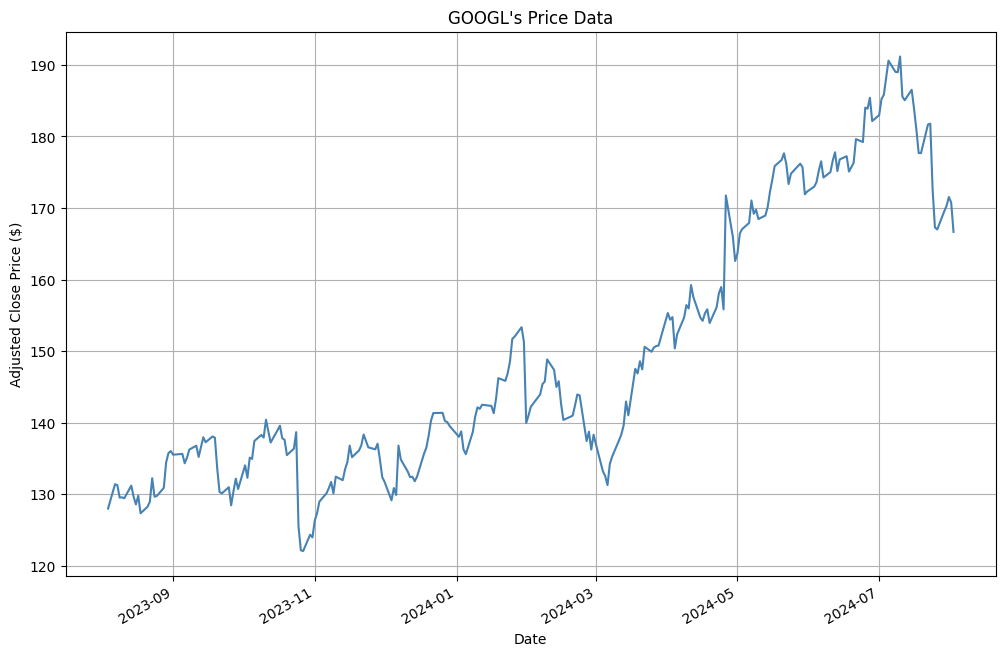

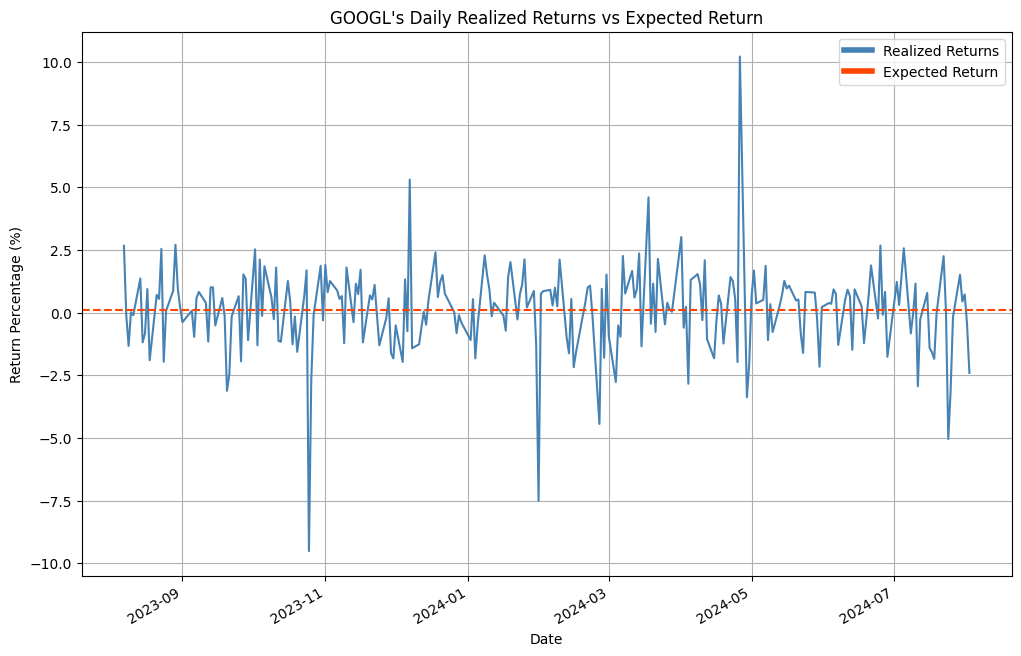

In [6]:
# Insert the stock's ticker symbol and the desired time period, the syntax is:
# display_stock_data(ticker symbol, period)
# or
# display_stock_data(ticker symbol, start='YYYY-MM-DD',end='YYYY-MM-DD'.)
# Possible period values are: 
#   - 1d (1 day)
#   - 5d (5 days)
#   - 1mo (1 month)
#   - 3mo (3 months)
#   - 6mo (6 months)
#   - 1y (1 year)
#   - 2y (2 years)
#   - 5y (5 years)
#   - 10y (10 years)
#   - ytd (year to date)
#   - max (maximum available period)
# 
# You can also specify a custom date range using 'start' and 'end' in the format 'YYYY-MM-DD'.
# Note that if the 'period' value. is set, it'll override both 'start' and 'end'.
# If only one of 'start' or 'end' is provided, the other will default
# The default period is 'max', the default start is 99 year ago, and the default end is today

display_stock_data('005930.KS', start='2023-08-04')
display_stock_data('GOOGL', start='2023-08-04')

In [9]:
display(get_full_portfolio_data(['IVV','GOOGL','005930.KS'],[128.,230.,175.],['2023-08-04','2024-01-18','2023-12-15']))

,Stock_Symbol,Money_Invested,Start,End,Portfolio_Return,Portfolio_Risk
0,IVV,128.0,2023-08-04,None,0.051179,None
1,GOOGL,230.0,2024-01-18,None,0.075451,None
2,005930.KS,175.0,2023-12-15,None,0.043434,None
